In [2]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd

In [ ]:
#timestep = 0.5

In [367]:
Distance = 2*np.array(
[[1, 8,  12,  14,  10,  16],
[8,  1,  6,  18,  16,  16],
[12,  18,  1.5,  12,  6,  4],
[16,  14,  4,  1,  16,  12],
[18,  16,  10,  4,  2,  2],
[16,  18,  4,  12,  2,  2]])
G = nx.DiGraph()
for i in range(len(Distance)):
    G.add_edge(i+1,i+1,weight=Distance[i][i]) 
    for j in range(len(Distance[0])):
           G.add_edge(i+1,j+1,weight=Distance[i][j]) 

In [368]:
def calculate_time(Distance,path):
    pair = [[path[i]-1,path[i+1]-1] for i in range(len(path)-1)]
    sum = 0
    for i in pair:
        sum+= Distance[i[0]][i[1]]
    return sum

In [372]:
def distance(city1,city2):
    if (city1!=city2):
        return calculate_time(Distance,nx.shortest_path(G,source=city1,target=city2, weight='weight'))
    else:
        return Distance[city1-1][city1-1]

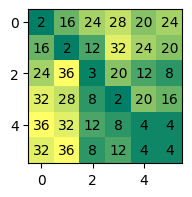

In [373]:
Shortest_time = [[distance(i,j) for j in range(1,7)] for i in range(1,7)]
Shortest_route = [[nx.shortest_path(G,source=i,target=j, weight='weight') for j in range(1,7)] for i in range(1,7)]
# Create a sample 2D array
data = np.array(Shortest_time)
plt.figure(figsize=(2,2))
# Display the image using imshow
plt.imshow(data, cmap='summer')

# Add annotations for each value in the array
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        plt.annotate(str(int(data[i, j])), xy=(j, i), ha='center', va='center', color='black')

# Show the plot
plt.show()


In [534]:
N = np.array([50000,80000,30000,55000,35000,20000])

In [392]:
def patient_gen(patient_list,P):
    #P = prob array patient
    P = np.array(P)
    tmp_r = np.random.random((1,6))
    return  np.vstack((patient_list,np.where(tmp_r < P, 1, 0)))

In [557]:
def time_cal(position,destination): #destination 0-5
    position = np.array(position)
    if (np.any(position < 0)):
        a = np.where(position==1)[0][0]
        b = np.where(position==-1)[0][0]
        d1 = Shortest_time[a][destination]+position[-1]
        #Side note: if b = destination -> shortest_time[b][destination] must be zero
        d2 = Shortest_time[b][destination]*(b!=destination) + (Shortest_time[a][b] - position[-1])
        return [d1,d2]
    else :
        return [Shortest_time[np.where(position==1)[0][0]][destination]]
        #stationary 
        

In [175]:
list = np.array([1,2,3,1])
np.min(list)

1

In [177]:
filter = np.array([1,2,4,0,0])
np.where(filter == np.min(filter))

(array([3, 4]),)

In [566]:
#rewamp model
class ambulance():
    def __init__(self,initial_position): #initial_position: 0 to 5
        self.position = np.zeros((1,7))[0]; self.position[initial_position] = 1 
        #(0,1,0,0,0,0,0) -> ambulance in zone 2
        #(0,1,0,0,0,0,1) -> ambulance in zone 2 going into zone 2
        #(0,1,-1,0,0,0,1) -> ambulance travel from zone 2 to 3 and travel for 1 min from 2
        self.station = initial_position
        self.time = 0
        self.status = 0
        self.patient = -1 #free
        self.t_mark = -1
        self.count = 0
        self.route = [initial_position+1] #checklist for traveling
    def update(self,patient_list):
        #status 0 = find patient stay at the station; status 1 = traveling to carry patient (+time sending patient to the hospital);
        #status 2 = coming back to the station
        #find patient from current location
        if (self.status == 0):
            
            #scroll down from w: self.time -> self.time - 16
            patient_select = patient_list.copy()[max(0,self.time-15):self.time+1] 
            l = len(patient_select)
            position = np.where(self.position==1)[0][0]
            self.route = [position+1]
            for n,i in enumerate(patient_select):
                #if see at least one satisfying condition -> break loop
                tmp = []
                for j in range(6):
                    if (len(patient_select)-n-1 + min(time_cal(self.position,j)) <= 8 and i[j]!=0): #not include extra time
                        tmp.append(j)
                
                if (len(tmp)!=0):
                    self.t_mark = self.time + n-len(patient_select)+1;
                    #choose the minimum time among time_cal(position,j) j in tmp
                    filter = np.array([min(time_cal(self.position,j)) for j in tmp])
                    self.patient = tmp[np.random.choice(np.where(filter == np.min(filter))[0])]
                    self.route = Shortest_route[position][self.patient] #route is indexed by 1-6
                    #initialize position
                    
                    if (len(self.route) != 1):
                        self.position =  np.zeros((1,7))[0]; self.position[self.route[0]-1] = 1; self.position[self.route[1]-1] = -1; 
                        self.position[6] = Shortest_time[self.route[0]-1][self.route[1]-1]
                    self.status = 1
                    patient_list[self.t_mark][self.patient] = 0
                    self.route = np.delete(self.route.copy(),0)
                    break
        elif (self.status == 1):
            #traveling time
            if (self.position[6]==0):
                if (len(self.route)==1):
                    #arrived/buffer hospital time
                     self.position =  np.zeros((1,7))[0]; self.position[self.route[0]-1] = 1; 
                     self.position[6] = Shortest_time[self.route[0]-1][self.route[0]-1]
                     self.route = np.delete(self.route.copy(),0)
                elif (len(self.route)>1):
                    self.position[self.route[0]-1] = 1
                    self.position[self.route[1]-1] = -1 #Next destination
                    self.position[6] = Shortest_time[self.route[0]-1][self.route[1]-1]
                    self.route = np.delete(self.route.copy(),0)
                else:
                    position = np.where(self.position==1)[0][0]
                    #finish clearing patient
                    
                    self.count += 1
                    self.patient = -1
                    t_mark = -1
                    self.status = 2 #change to 2
                    
                    position = np.where(self.position.copy()==1)[0][0]
                    if (position == self.station):
                        self.status = 0
                    else:
                        self.route = Shortest_route[position][self.station]
                        self.position = np.zeros((1,7))[0]
                        self.position[position] = 1
                        self.position[self.route[1]-1]=-1
                        self.position[6] = Shortest_time[self.route[0]-1][self.route[1]-1]
                        self.route = np.delete(self.route.copy(),0)
            else:
                self.position[6]-=1
        else:
            
            if (self.position[6]==0):
                
                if (len(self.route)==1):
                    #arrived/buffer hospital time
                     self.position =  np.zeros((1,7))[0]; self.position[self.route[0]-1] = 1; 
                     self.position[6] = Shortest_time[self.route[0]-1][self.route[0]-1]
                     #self.route = np.delete(self.route.copy(),0)
                elif (len(self.route)>1):
                    self.position[self.route[0]-1] = 1
                    self.position[self.route[1]-1] = -1 #Next destination
                    self.position[6] = Shortest_time[self.route[0]-1][self.route[1]-1]
                    self.route = np.delete(self.route.copy(),0)
                else:
                    self.status = 0 
            else:
                #find additional patient
                patient_select = patient_list.copy()[max(0,self.time-15):self.time+1] 
                l = len(patient_select)
                position = np.where(self.position==1)[0][0]
                for n,i in enumerate(patient_select):
                    #if see at least one satisfying condition -> break loop
                    tmp = []
                    for j in range(6):
                        if (len(patient_select)-n-1 + min(time_cal(self.position,j)) <= 8 and i[j]!=0): #not include extra time
                            tmp.append(j)
                    
                    if (len(tmp)!=0):
                        next = self.route[0] - 1
                        
                        self.t_mark = self.time + n-len(patient_select)+1;
                        #choose the minimum time among time_cal(position,j) j in tmp
                        filter = np.array([min(time_cal(self.position,j)) for j in tmp])
                        self.patient = tmp[np.random.choice(np.where(filter == np.min(filter))[0])]
                        tmp2 = np.argmin(time_cal(self.position,self.patient))
                        patient_list[self.t_mark][self.patient] = 0
                        if (tmp2 == 0): #go back to city index (1)
                            self.route = Shortest_route[position][self.patient]
                            #Same self.position
                        else:  #go back to city index (-1)
                            self.route = Shortest_route[next][self.patient]
                            self.position = -self.position.copy(); self.position[6]*=-1
                            #reverse state
                        self.status = 1
                        break
                    
                #else
                self.position[6]-=1
        self.time+=1
        

In [573]:
c1 = ambulance(0)
c2 = ambulance(1)
patient_list = np.zeros((1,6))[0]
count_list = []
position_list = []
status_list = []
for i in range(2880):
    
    print("Iteration ",i," Minute ",i/2," Hour ", i/120,end="\r")
    patient_list = patient_gen(patient_list, [0.017,0.017,0.017,0.017,0.017,0.017])
    c1.update(patient_list)
    c2.update(patient_list)
    position_list.append(np.array([np.where(c1.position==1)[0][0],np.where(c2.position==1)[0][0]]))
    count_list.append(np.array([c1.count,c2.count]))
    status_list.append(np.array([c1.status,c2.status]))
    

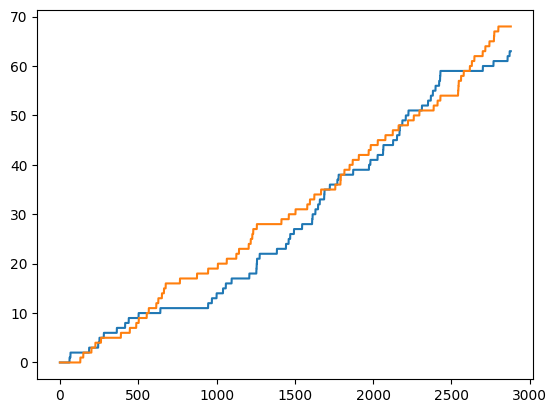

In [574]:
A = count_list
plt.plot(np.array(A)[:,0])
plt.plot(np.array(A)[:,1])